# Recommender Systems 2021/2022

## Practice - Hybrid Recommenders

### There are several strategies you can adopt to create hybrid models
* Stacking URM, ICM, UCM
* Combine already available models all with the same model structure
* Combine already available models with different model structure
* Combine already available models with rating prediction vs ranking loss functions
* CF-CBF Hybrids
* User-wise discrimination

## Some basic information about hybrid models

### The way to go to achieve the best recommendation quality
In order to create an effective hybrid model you need a few things:
* Reasonably well performing models
* Models must look at the task in (at least slightly) different ways
* It must be possible to combine the two

There are many different types of hybrids, we will be covering only some of them.


### In Movielens10M we have the usual URM, but also several ICMs

In [22]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.8)

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: <class 'Data_manager.Dataset.Dataset'>
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_year, Value range: 6.00E+00 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




In [23]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[5])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[5, 10])

EvaluatorHoldout: Ignoring 69630 ( 0.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 69814 ( 0.1%) Users that have less than 1 test interactions


# Stacking

A simple idea is to look at both iteractions and features as a similar type of information. Given an item, you can see the users that interacted with it as *features* of that item, in the same way as its genre.

To do so, you can concatenate URM and ICM in a single data structure of shape |n_users + n_features|x|n_items|

WARNING: You are creating a new matrix that can be used as URM or ICM interchangeably and plugged into any model you already have. This gives you flexibility but requires caution, for example, what happens if you use that stacked URM in a UserBasedKNN vs in an ItemBasedKNN? (hint: only in one it makes sense)

In [29]:
import scipy.sparse as sps

ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

stacked_URM = sps.vstack([URM_train, ICM_genres.T])
stacked_URM = sps.csr_matrix(stacked_URM)

stacked_ICM = sps.csr_matrix(stacked_URM.T)

stacked_URM, stacked_ICM

(<69898x10681 sparse matrix of type '<class 'numpy.float64'>'
 	with 6421598 stored elements in Compressed Sparse Row format>,
 <10681x69898 sparse matrix of type '<class 'numpy.float64'>'
 	with 6421598 stored elements in Compressed Sparse Row format>)

At this point you can use it to train any model you have. Suggestions:
* If one of the two is much larger than the other (like in this case, 60k users vs 20 features) the smaller will be overwhelmed numerically. Add a weight to the smaller one to increase its importance (will only work for models that allow explicit interactions, will not work with models that use implicit ones)
* If the ICM has a bad recommendation quality, maybe stacking will not help
* When computing a item-based similarity, you can also use only *some* of the features or users. This is called feature selection and is a wide area of research.

In [25]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender_object = ItemKNNCFRecommender(stacked_URM)
recommender_object.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

Similarity column 10681 (100.0%), 793.35 column/sec. Elapsed time 13.46 sec
EvaluatorHoldout: Processed 69630 (100.0%) in 59.25 sec. Users per second: 1175


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.213112,0.223299,0.089927,0.136423,0.142041,0.388237,0.170831,0.126483,0.629154,0.516675,...,0.118996,0.996451,0.626921,0.021371,8.023961,0.993385,0.108403,0.707623,1.699083,0.045315


In [26]:
recommender_object = ItemKNNCBFRecommender(URM_train, stacked_ICM)
recommender_object.fit()

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ItemKNNCBFRecommender: URM Detected 58 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 777.60 column/sec. Elapsed time 13.74 sec
EvaluatorHoldout: Processed 69630 (100.0%) in 56.53 sec. Users per second: 1232


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.213112,0.223299,0.089927,0.136423,0.142041,0.388237,0.170831,0.126483,0.629154,0.516675,...,0.118996,0.996451,0.626921,0.021371,8.023961,0.993389,0.109773,0.708528,1.6989,0.045492


The framework already includes a model that does stacking, but only applied to the KNNs

In [30]:
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

recommender_object = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_genres)
recommender_object.fit(ICM_weight = 10.0)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ItemKNN_CFCBF_HybridRecommender: URM Detected 58 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 908.87 column/sec. Elapsed time 11.75 sec
EvaluatorHoldout: Processed 69630 (100.0%) in 49.99 sec. Users per second: 1393


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.213328,0.223545,0.090066,0.136778,0.142497,0.388904,0.17124,0.126657,0.629068,0.517804,...,0.115158,0.996451,0.626835,0.021463,8.03255,0.99343,0.110245,0.709286,1.695189,0.045518


# Hybrid of models with the same structure

The underlying idea is that if you have some models with the same underlying structure, you can merge them in a single one. The result is to define a function that give the various model's parameters creates a new model with its own parameters.
In this example we will see how to combine different item-item similarity models in a new one.

In particular: `ItemKNNCFRecommender` and `P3AlphaRecommender`. Both use and learn a similarity matrix to provide recommendations. Notice that here we are merging a KNN-based with a Graph-based model.


In [31]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit()

ItemKNNCFRecommender: URM Detected 58 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 973.05 column/sec. Elapsed time 10.98 sec


In [32]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit()

P3alphaRecommender: URM Detected 58 ( 0.5%) items with no interactions.


Now that we have both models fit with `URM_train` how can we merge them?


Well, we could take the advantage that they have the same underlying structure, i.e. a similarity matrix

In [33]:
itemKNNCF.W_sparse

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 530972 stored elements in Compressed Sparse Row format>

In [34]:
P3alpha.W_sparse

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 199213 stored elements in Compressed Sparse Row format>

When we create hybrids we always have to account for:
* A weight, which is a hyperparameter to tune. 
* What is the range and distribution of the values we are merging

Imagine that the values of one similarity are orders of magnitude higher than the other, then the smaller values would get absorbed by the bigger ones. 

In [35]:
alpha = 0.7
new_similarity = (1 - alpha) * itemKNNCF.W_sparse + alpha * P3alpha.W_sparse
new_similarity

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 710216 stored elements in Compressed Sparse Row format>

Moreover, we can apply the same optimizations to this similarity as we applied to the others (for example: topK neighbors)

The framework includes a recommender class which supports a custom similarity

In [36]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

recommender_object = ItemKNNCustomSimilarityRecommender(URM_train)
recommender_object.fit(new_similarity)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ItemKNNCustomSimilarityRecommender: URM Detected 58 ( 0.5%) items with no interactions.
EvaluatorHoldout: Processed 69630 (100.0%) in 44.08 sec. Users per second: 1580


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.214824,0.225279,0.091285,0.13786,0.143686,0.391352,0.173486,0.128125,0.632859,0.521458,...,0.116562,0.996451,0.630613,0.020387,7.933178,0.992686,0.104717,0.700512,1.745572,0.045308


# Hybrid of models with different structure

We just saw the case where models had compatible structure (ItemKNN with P3Alpha) but there are certain cases where we want to combine recommenders with different underlying structures. For instance ItemKNN and UserKNN or ItemKNN with PureSVD.

In this case we cannot combine the model parameters themselves, rather we can combine the *predictions*.

In [37]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()

PureSVDRecommender: URM Detected 58 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 5.58 sec


We can combine the predictions via a weighted average

In [44]:
user_id = 50

item_scores_itemknn = itemKNNCF._compute_item_score(user_id)
item_scores_itemknn

array([ 0.64596045, 17.556862  , 17.287127  , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [45]:
item_scores_puresvd = pureSVD._compute_item_score(user_id)
item_scores_puresvd

array([-0.02908717,  0.89519346,  0.9455003 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

As you can see, we provide a score for every item in the dataset in both recommenders. 

Remember that after calculating these scores, we sort them and take the n-most relevant ones.

Again we use a weight

In [46]:
alpha = 0.7

new_item_scores = alpha * item_scores_itemknn + (1 - alpha) * item_scores_puresvd
new_item_scores

array([ 0.44344616, 12.558362  , 12.384639  , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

Now we create a recommeder class. Note that again we can build a hybrid combining any number of models

In [52]:
from Recommenders.BaseRecommender import BaseRecommender

class ScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"

    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
    def fit(self, alpha = 0.5):
        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        # In a simple extension this could be a loop over a list of pretrained recommender objects
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights

In [53]:
scoreshybridrecommender = ScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
scoreshybridrecommender.fit(alpha = 0.5)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

ScoresHybridRecommender: URM Detected 58 ( 0.5%) items with no interactions.
EvaluatorHoldout: Processed 69630 (100.0%) in 55.19 sec. Users per second: 1262


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_ITEM_CORRECT,COVERAGE_USER,COVERAGE_USER_CORRECT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.214824,0.225279,0.091285,0.13786,0.143686,0.391352,0.173486,0.128125,0.632859,0.521458,...,0.116562,0.996451,0.630613,0.020387,7.933178,0.992686,0.104717,0.700512,1.745572,0.045308


# Models with rating prediction vs ranking loss functions

Sometimes we have models that optimize different loss functions, one BPR (ranking) and another rating prediction (MSE). For instance:
- SLIMBPR and SLIM EN/MSE
- FunkSVD and MFBPR
- ...

This brings another important problem, for rank-based models there is no clear meaning for the *absolute value* of the prediction. A value of 15.245 may be low or high, depending on the *other* values.

In those cases it becomes essential to include a *normalization* on the weights, to ensure that the values are, at least, in the same range for all models. Many normalizations can be used: min/max, l1, l2, other nonlinear functions (sigmoid, ...)


In [54]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_FunkSVD_Cython

funk_svd_recommender = MatrixFactorization_FunkSVD_Cython(URM_train)
funk_svd_recommender.fit(epochs=50)

MatrixFactorization_FunkSVD_Cython_Recommender: URM Detected 58 ( 0.5%) items with no interactions.
FUNK_SVD: Processed 6401000 (100.0%) in 7.37 sec. MSE loss 2.15E+00. Sample per second: 868550
FUNK_SVD: Epoch 1 of 50. Elapsed time 6.88 sec
FUNK_SVD: Processed 6401000 (100.0%) in 7.29 sec. MSE loss 1.13E+00. Sample per second: 877955
FUNK_SVD: Epoch 2 of 50. Elapsed time 13.80 sec
FUNK_SVD: Processed 6401000 (100.0%) in 7.33 sec. MSE loss 1.13E+00. Sample per second: 873560
FUNK_SVD: Epoch 3 of 50. Elapsed time 20.84 sec
FUNK_SVD: Processed 6401000 (100.0%) in 7.08 sec. MSE loss 1.13E+00. Sample per second: 903572
FUNK_SVD: Epoch 4 of 50. Elapsed time 27.59 sec
FUNK_SVD: Processed 6401000 (100.0%) in 6.71 sec. MSE loss 1.12E+00. Sample per second: 954254
FUNK_SVD: Epoch 5 of 50. Elapsed time 34.22 sec
FUNK_SVD: Processed 6401000 (100.0%) in 7.85 sec. MSE loss 1.12E+00. Sample per second: 815089
FUNK_SVD: Epoch 6 of 50. Elapsed time 41.36 sec
FUNK_SVD: Processed 6401000 (100.0%) in 7.5

In [56]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

slim_bpr_recommender = SLIM_BPR_Cython(URM_train)
slim_bpr_recommender.fit(epochs=50)

SLIM_BPR_Recommender: URM Detected 58 ( 0.5%) items with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 69878 (100.0%) in 1.27 sec. BPR loss is 3.53E-04. Sample per second: 55004
SLIM_BPR_Recommender: Epoch 1 of 50. Elapsed time 0.80 sec
Processed 69878 (100.0%) in 1.14 sec. BPR loss is 1.12E-03. Sample per second: 61163
SLIM_BPR_Recommender: Epoch 2 of 50. Elapsed time 1.67 sec
Processed 69878 (100.0%) in 0.90 sec. BPR loss is 1.91E-03. Sample per second: 77579
SLIM_BPR_Recommender: Epoch 3 of 50. Elapsed time 2.43 sec
Processed 69878 (100.0%) in 1.71 sec. BPR loss is 2.70E-03. Sample per second: 40939
SLIM_BPR_Recommender: Epoch 4 of 50. Elapsed time 3.23 sec
Processed 69878 (100.0%) in 1.27 sec. BPR loss is 3.54E-03. Sample per second: 54879
SLIM_BPR_Recommender: Epoch 5 of 50. Elapsed 

Both of these recommenders have the `_compute_item_score` function. However, the scores might be totally different.

Let's see

In [57]:
funk_svd_score = funk_svd_recommender._compute_item_score(user_id)
funk_svd_score

array([3.51716182, 3.39194013, 3.17708474, ..., 3.57504768, 3.54760804,
       3.56342782])

In [58]:
slim_bpr_score = slim_bpr_recommender._compute_item_score(user_id).flatten()
slim_bpr_score

array([0.02191568, 0.73489636, 0.7966265 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Here is where things get complicated. You see, the scores that each function computes have completely different meanings, we cannot just join them as if they are the same thing. 

Let's calculate some percentiles and do some visualizations on the scores.

In [59]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

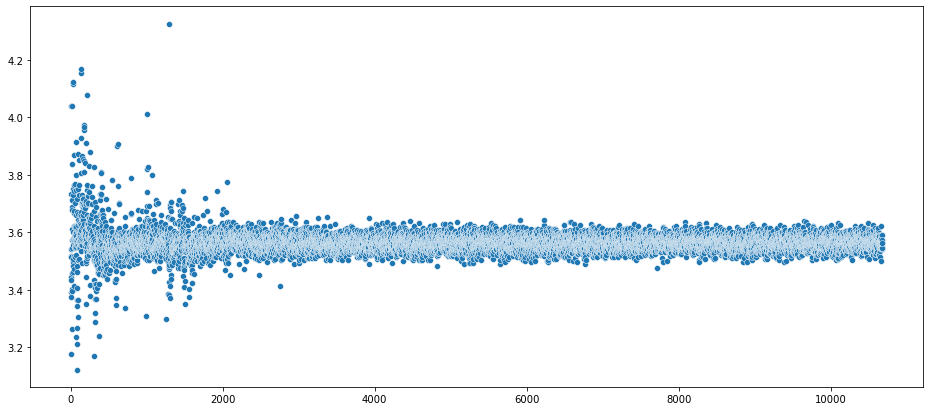

In [60]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)

In [61]:
np.percentile(funk_svd_score, [0, 25, 50, 75, 100])


array([3.12335783, 3.54729815, 3.56472782, 3.582165  , 4.32633879])

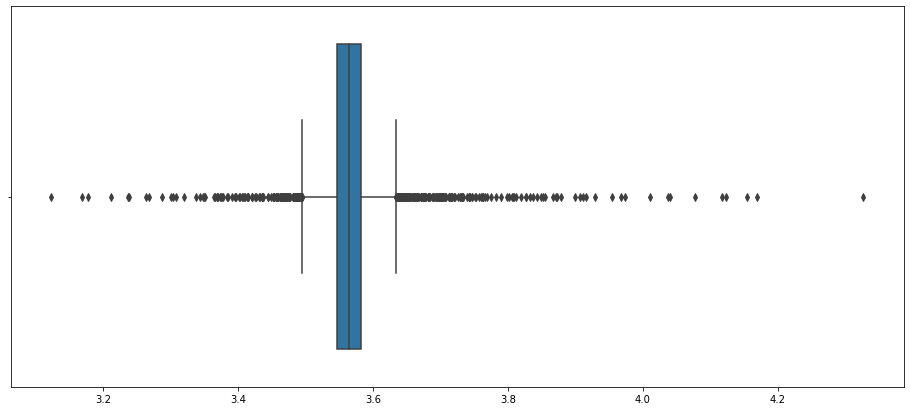

In [62]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=funk_svd_score)

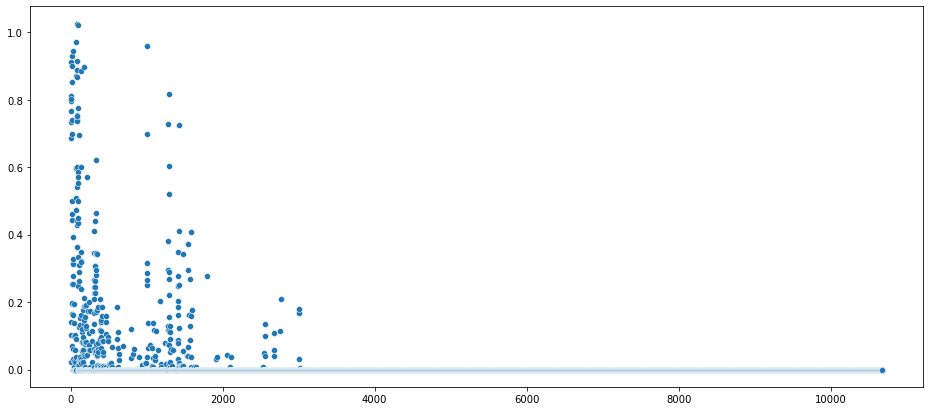

In [63]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=slim_bpr_score)

In [64]:
np.percentile(slim_bpr_score, [0, 25, 50, 75, 100])


array([0.        , 0.        , 0.        , 0.        , 1.02546418])

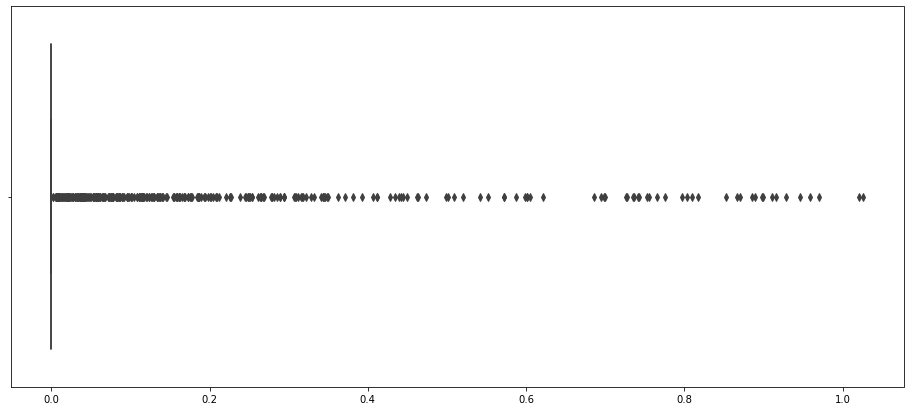

In [65]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=slim_bpr_score)

As you can see from the plots and the percentiles, the values held in each score array is totally different from one to another. 

As such, we need a way to _normalize_ these scores to be able to merge them into one.

[3.51716182 3.39194013 3.17708474 ... 3.57504768 3.54760804 3.56342782] 4.326338790859685 368.53668611969107 4.326338790859685 3.123357828479471


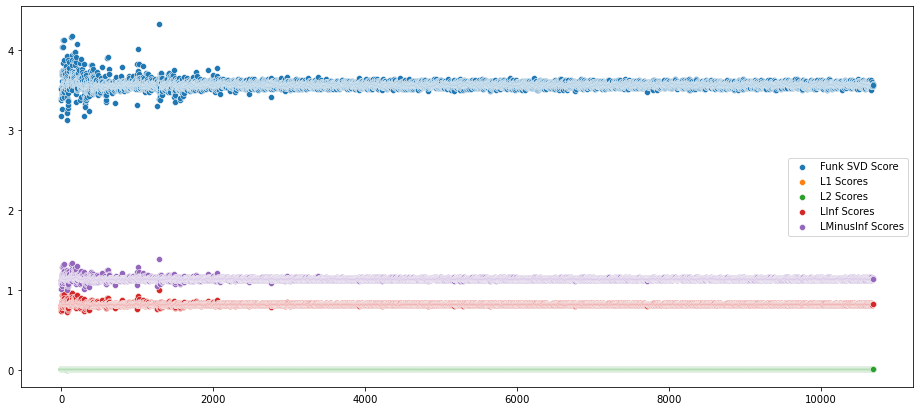

In [66]:
l1_funk_svd = LA.norm([funk_svd_score], 1)
l1_funk_svd_scores = funk_svd_score / l1_funk_svd

l2_funk_svd = LA.norm([funk_svd_score], 2)
l2_funk_svd_scores = funk_svd_score / l2_funk_svd

linf_funk_svd = LA.norm(funk_svd_score, np.inf)
linf_funk_svd_scores = funk_svd_score / linf_funk_svd

lminusinf_funk_svd = LA.norm(funk_svd_score, -np.inf)
lminusinf_funk_svd_scores = funk_svd_score / lminusinf_funk_svd

print(funk_svd_score, l1_funk_svd, l2_funk_svd, linf_funk_svd, lminusinf_funk_svd)

_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)
ax = sns.scatterplot(data=l1_funk_svd_scores) 
ax = sns.scatterplot(data=l2_funk_svd_scores) 
ax = sns.scatterplot(data=linf_funk_svd_scores) 
ax = sns.scatterplot(data=lminusinf_funk_svd_scores) 
ax.legend(["Funk SVD Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Similarly, we can do the same with SLIM BPR scores

[0.02191568 0.73489636 0.7966265  ... 0.         0.         0.        ] 72.603714 6.0199294 1.0254642 0.0


<ipython-input-67-ed214cbf1a39>:11: RuntimeWarning: divide by zero encountered in true_divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr
<ipython-input-67-ed214cbf1a39>:11: RuntimeWarning: invalid value encountered in true_divide
  lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr


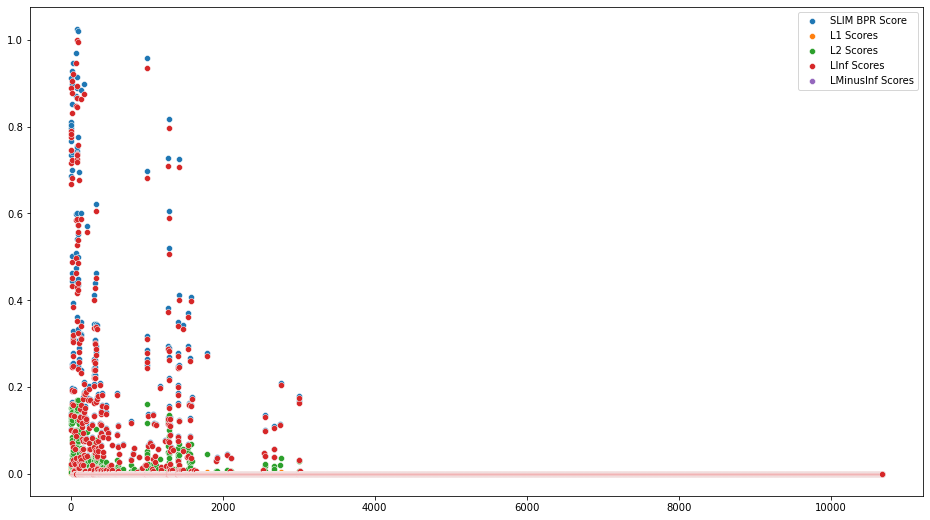

In [67]:
l1_slim_bpr = LA.norm(slim_bpr_score, 1)
l1_slim_bpr_scores = slim_bpr_score / l1_slim_bpr

l2_slim_bpr = LA.norm(slim_bpr_score, 2)
l2_slim_bpr_scores = slim_bpr_score / l2_slim_bpr

linf_slim_bpr = LA.norm(slim_bpr_score, np.inf)
linf_slim_bpr_scores = slim_bpr_score / linf_slim_bpr

lminusinf_slim_bpr = LA.norm(slim_bpr_score, -np.inf)
lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr

print(slim_bpr_score, l1_slim_bpr, l2_slim_bpr, linf_slim_bpr, lminusinf_slim_bpr)

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=slim_bpr_score)
ax = sns.scatterplot(data=l1_slim_bpr_scores) 
ax = sns.scatterplot(data=l2_slim_bpr_scores) 
ax = sns.scatterplot(data=linf_slim_bpr_scores) 
ax = sns.scatterplot(data=lminusinf_slim_bpr_scores) 
ax.legend(["SLIM BPR Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now that we have *normalized* the different item score vectors, we can merge the models.

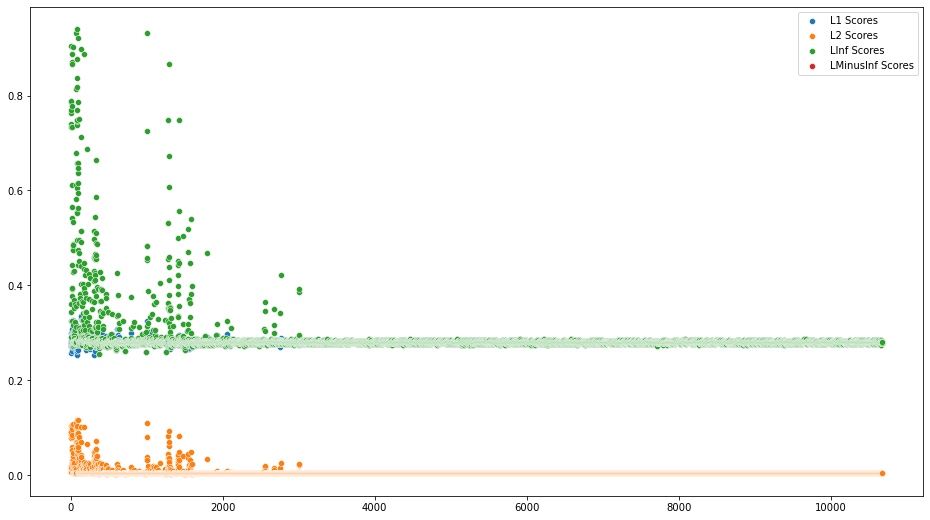

In [68]:
lambda_weights = 0.66

l1_new_scores = lambda_weights * l1_slim_bpr_scores + (1 - lambda_weights) * l1_funk_svd_scores
l2_new_scores = lambda_weights * l2_slim_bpr_scores + (1 - lambda_weights) * l2_funk_svd_scores
linf_new_scores = lambda_weights * linf_slim_bpr_scores + (1 - lambda_weights) * linf_funk_svd_scores
lminusinf_new_scores = lambda_weights * lminusinf_slim_bpr_scores + (1 - lambda_weights) * lminusinf_funk_svd_scores

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=l1_new_scores)
ax = sns.scatterplot(data=l2_new_scores) 
ax = sns.scatterplot(data=linf_new_scores) 
ax = sns.scatterplot(data=lminusinf_new_scores) 
ax.legend(["L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now, we have everything to create our hybrid.

In [78]:
class DifferentLossScoresHybridRecommender(BaseRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = sps.csr_matrix(URM_train)
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
        
    def fit(self, norm, alpha = 0.5):

        self.alpha = alpha
        self.norm = norm


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights



In [ ]:
recommender_object = DifferentLossScoresHybridRecommender(URM_train, funk_svd_recommender, slim_bpr_recommender)

for norm in [1, 2, np.inf, -np.inf]:

    recommender_object.fit(norm, alpha = 0.66)
    
    print("Results with norm: {}".format(norm))
    result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
    print(result_df["MAP"])

DifferentLossScoresHybridRecommender: URM Detected 58 ( 0.5%) items with no interactions.
Results with norm: 1
EvaluatorHoldout: Processed 69630 (100.0%) in 1.33 min. Users per second: 871
cutoff
5    0.107598
Name: MAP, dtype: object
Results with norm: 2
EvaluatorHoldout: Processed 19000 (27.3%) in 5.05 min. Users per second: 63


## Important note:

You can build a hybrid with any number of techniques and models, be advised however that optimizing them is difficult.
* If you use already trained and optimized models and try to combine them you have a weight per each model and possibly a normalization. If you put together 10 models it will be difficult for the optimizer to find good hyperparameters due to a number of problems, for example the noise introduced by the lower performing algorithms;
* If you decide to try to optimize both the hybrid hyperparameters and each single model hyperparameters all at once, you end up with hundreds of hyperparameters to optimize. In theory you could be able to find a better result, in practice you will likely not.
* Some strategies can be used to minimize this, for example some smart initial points you provide to the optimizer... Maybe you start from all the hyperparameter configurations of the single models taken independently that you have already optimized, you use them as initialization points for the optimizer and then you try to *further* optimize them as part of the hybrid. (may be complicated, result is not guaranteed) 

A good solution is to proceed incrementally. For example:
* Start with the best model and set a weight and normalization, let's say 1.0 and l1;
* Add the second-best model and try to create a hybrid of the two optimizing only weight and normalization of the model you are trying to add;
* Once the optimization concludes, check if the hybrid is better than before or not. If it is better keep the new hybrid, if not remove the second-best model.
* Continue trying to add the third-best, fourth-best and so on...
* If you are lucky every now and then a new model can be added and the quality improves. (again, result not guaranteed)


Alternatively you can combine the model predictions with more complex strategies, for example with XGBoost. This is usually the go-to approach for hybrids that we use in the international challenges but goes beyond the scope of this course.

# Recommender Systems 2020/2021

## Practice 12 - Hybrid Recommenders

### Outline 
* Models with same model structure
* Models with different model structure
* Models with different loss functions
* __CF-CBF Hybrids__
* __User-wise discrimination__

## CF-CBF Hybrids... what are those?

Until now, we have seen how to create hybrids of different recommender types. There's a special type of hybrid that is really useful and powerful.

Let's dive into CF-CBF hybrids, which merge the benefits of content-based and collaborative approaches.





Beforehand, we need an ICM, let's have a look at the one we already have with the dataset.

In [46]:
datasets_dict.AVAILABLE_ICM

{'ICM_genres': <10681x20 sparse matrix of type '<class 'numpy.float64'>'
 	with 21564 stored elements in Compressed Sparse Row format>,
 'ICM_tags': <10681x10217 sparse matrix of type '<class 'numpy.float64'>'
 	with 108563 stored elements in Compressed Sparse Row format>,
 'ICM_all': <10681x10237 sparse matrix of type '<class 'numpy.float64'>'
 	with 130127 stored elements in Compressed Sparse Row format>}

In [47]:
ICM_genres = datasets_dict.AVAILABLE_ICM[" "]
print(ICM_genres)

  (0, 3)	1.0
  (0, 5)	1.0
  (0, 269)	1.0
  (0, 272)	1.0
  (0, 273)	1.0
  (0, 1530)	1.0
  (0, 1603)	1.0
  (1, 7)	1.0
  (1, 8)	1.0
  (1, 9)	1.0
  (1, 28)	1.0
  (1, 56)	6.0
  (1, 132)	2.0
  (1, 408)	1.0
  (1, 514)	1.0
  (1, 698)	7.0
  (1, 699)	7.0
  (1, 736)	1.0
  (1, 1543)	1.0
  (1, 1588)	3.0
  (1, 2384)	1.0
  (1, 2591)	1.0
  (1, 2654)	1.0
  (1, 4125)	1.0
  (1, 5153)	1.0
  :	:
  (10680, 809)	1.0
  (10680, 1059)	1.0
  (10680, 1568)	1.0
  (10680, 1587)	1.0
  (10680, 1588)	1.0
  (10680, 1752)	1.0
  (10680, 1810)	1.0
  (10680, 1844)	1.0
  (10680, 1845)	1.0
  (10680, 1936)	1.0
  (10680, 2072)	1.0
  (10680, 2122)	1.0
  (10680, 2543)	1.0
  (10680, 2831)	1.0
  (10680, 3164)	1.0
  (10680, 3444)	1.0
  (10680, 3454)	1.0
  (10680, 3818)	1.0
  (10680, 4021)	1.0
  (10680, 4059)	1.0
  (10680, 4060)	1.0
  (10680, 4134)	1.0
  (10680, 4135)	1.0
  (10680, 4291)	1.0
  (10680, 4365)	1.0


Let's now create a CBF recommender.

In [48]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemknn_cbf_recommender = ItemKNNCBFRecommender(URM_train=URM_train, ICM_train=ICM_genres)
itemknn_cbf_recommender.fit(topK=50, shrink=100, similarity='cosine', normalize=True, feature_weighting="BM25")

ItemKNNCBFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 6642.62 column/sec, elapsed time 0.03 min


In [49]:
evaluator_test.evaluateRecommender(itemknn_cbf_recommender)

EvaluatorHoldout: Processed 46000 ( 65.89% ) in 30.57 sec. Users per second: 1505
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 46.03 sec. Users per second: 1517


({5: {'ROC_AUC': 0.22931199121487883,
   'PRECISION': 0.12256105421468352,
   'PRECISION_RECALL_MIN_DEN': 0.1235775501921495,
   'RECALL': 0.02656527645381269,
   'MAP': 0.08521790525754376,
   'MRR': 0.24900785409059106,
   'NDCG': 0.050473697603281534,
   'F1': 0.043665907597787004,
   'HIT_RATE': 0.6128052710735515,
   'ARHR': 0.32369118384302464,
   'NOVELTY': 0.005222372783963272,
   'AVERAGE_POPULARITY': 0.2826899801666599,
   'DIVERSITY_MEAN_INTER_LIST': 0.9530002532732225,
   'DIVERSITY_HERFINDAHL': 0.9905973205815849,
   'COVERAGE_ITEM': 0.3317105139968168,
   'COVERAGE_ITEM_CORRECT': 0.08819398932684205,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.3733077649617905,
   'DIVERSITY_GINI': 0.03150713705168565,
   'SHANNON_ENTROPY': 8.271938767456941},
  10: {'ROC_AUC': 0.2881456564912435,
   'PRECISION': 0.10081501110078202,
   'PRECISION_RECALL_MIN_DEN': 0.10685285033349025,
   'RECALL': 0.04174971063225307,
   'MAP': 0.059382301844613676,
   'MRR': 0.2

In [50]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(topK=50, shrink=100, similarity='cosine', normalize=True)

ItemKNNCFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 1093.91 column/sec, elapsed time 0.16 min


In [51]:
evaluator_test.evaluateRecommender(itemKNNCF)

EvaluatorHoldout: Processed 44000 ( 63.02% ) in 30.55 sec. Users per second: 1440
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 48.31 sec. Users per second: 1445


({5: {'ROC_AUC': 0.4267146506242705,
   'PRECISION': 0.3085640621643809,
   'PRECISION_RECALL_MIN_DEN': 0.31546515791743107,
   'RECALL': 0.1024625042526047,
   'MAP': 0.22922115193333484,
   'MRR': 0.5075260808326618,
   'NDCG': 0.14534086366720902,
   'F1': 0.1538404040757027,
   'HIT_RATE': 1.5428203108214567,
   'ARHR': 0.7582797393109967,
   'NOVELTY': 0.0044199157902269585,
   'AVERAGE_POPULARITY': 0.486716361874384,
   'DIVERSITY_MEAN_INTER_LIST': 0.9648175133573994,
   'DIVERSITY_HERFINDAHL': 0.9929607387453512,
   'COVERAGE_ITEM': 0.22881752644883438,
   'COVERAGE_ITEM_CORRECT': 0.12826514371313547,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.7267094078250665,
   'DIVERSITY_GINI': 0.02118929098505622,
   'SHANNON_ENTROPY': 8.035652707619706},
  10: {'ROC_AUC': 0.4897179541395699,
   'PRECISION': 0.2682546730645462,
   'PRECISION_RECALL_MIN_DEN': 0.3067981024680931,
   'RECALL': 0.16975158789534037,
   'MAP': 0.18831167926492626,
   'MRR': 0.5209750144

Let's think for a moment...

CBF receives a ICM and creates a similarity matrix from it.

CF does a similar thing, it receives a URM and creates a similarity matrix fron it.

In [52]:
ICM_genres

<10681x10237 sparse matrix of type '<class 'numpy.float64'>'
	with 130127 stored elements in Compressed Sparse Row format>

In [53]:
URM_train

<69878x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 7200739 stored elements in Compressed Sparse Row format>

Is there any way that we can create a new ICM (or URM) and use that as training for a CBF (CF) recommender?

We can try to merge them, or append one to another. But how?

If we look carefully, we see that `ICM_genres` is a $10681 \times 10237$ matrix and `URM_Train` is a $69878 \times 10681$.

If we transpose the URM, then we can think that the ratings given by each user are also "content" features, i.e., each column represents a content feature and the whole row contains the values of each content feature for a given item.

In [54]:
URM_train_t = URM_train.T
URM_train_t

<10681x69878 sparse matrix of type '<class 'numpy.float64'>'
	with 7200739 stored elements in Compressed Sparse Column format>

Now, as both the ICM_genres and URM_train_t have the same number of rows, and the same rows refers to the same item, then we can extend ICM_genres with the data in URM_train_t. 

More specifically, we can horizontally stack both matrices and obtain a new one being $10681 \times 80115 (10237 + 69878)$.

<img src="images/hstack_example.png" style="margin: 0 auto;" alt="Numpy Hstack">


As such, we can then treat this new matrix a new ICM, one that contains for each row the values of each content-feature for that item.


In [55]:
import scipy.sparse as sp

ICM_genres_plus_urm_train = sp.hstack([ICM_genres, URM_train_t], format="csr")
ICM_genres_plus_urm_train

<10681x80115 sparse matrix of type '<class 'numpy.float64'>'
	with 7330866 stored elements in Compressed Sparse Row format>

Now, we can basically provide this new ICM to a CBF recommender and get recommendations.

In [56]:
itemknn_cf_cbf_recommender = ItemKNNCBFRecommender(URM_train=URM_train, ICM_train=ICM_genres_plus_urm_train)
itemknn_cf_cbf_recommender.fit(topK=50, shrink=100, similarity='cosine', normalize=True, feature_weighting="BM25")

ItemKNNCBFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 1031.36 column/sec, elapsed time 0.17 min


In [57]:
evaluator_test.evaluateRecommender(itemknn_cf_cbf_recommender)

EvaluatorHoldout: Processed 44000 ( 63.02% ) in 30.28 sec. Users per second: 1453
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 47.95 sec. Users per second: 1456


({5: {'ROC_AUC': 0.437768865334572,
   'PRECISION': 0.31632743679734115,
   'PRECISION_RECALL_MIN_DEN': 0.32389290744594573,
   'RECALL': 0.10857658633997928,
   'MAP': 0.2371946891388031,
   'MRR': 0.5216584306142319,
   'NDCG': 0.15145983713117608,
   'F1': 0.16166358228164382,
   'HIT_RATE': 1.5816371839862493,
   'ARHR': 0.7819382176704652,
   'NOVELTY': 0.0043889087481640875,
   'AVERAGE_POPULARITY': 0.5046561894956612,
   'DIVERSITY_MEAN_INTER_LIST': 0.9587387591375716,
   'DIVERSITY_HERFINDAHL': 0.9917450053152773,
   'COVERAGE_ITEM': 0.2236681958618107,
   'COVERAGE_ITEM_CORRECT': 0.12601816309334332,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.7379146512493202,
   'DIVERSITY_GINI': 0.01857842797229788,
   'SHANNON_ENTROPY': 7.825835354797723},
  10: {'ROC_AUC': 0.5019900962748437,
   'PRECISION': 0.27091455990834723,
   'PRECISION_RECALL_MIN_DEN': 0.311930538645795,
   'RECALL': 0.1760549169306654,
   'MAP': 0.1939508686298397,
   'MRR': 0.53446856147

Moreover, we can weight the values of the original ICM.


In [58]:
ICM_weight = 10
ICM_genres_weight = ICM_genres * ICM_weight

ICM_genres_weight_plus_urm_train = sp.hstack([ICM_genres_weight, URM_train_t], format="csr")
itemknn_cf_cbf_w_recommender = ItemKNNCBFRecommender(URM_train=URM_train, ICM_train=ICM_genres_weight_plus_urm_train)
itemknn_cf_cbf_w_recommender.fit(topK=50, shrink=100, similarity='cosine', normalize=True, feature_weighting="BM25")

ItemKNNCBFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 1046.53 column/sec, elapsed time 0.17 min


In [59]:
evaluator_test.evaluateRecommender(itemknn_cf_cbf_w_recommender)

EvaluatorHoldout: Processed 44000 ( 63.02% ) in 30.24 sec. Users per second: 1455
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 47.76 sec. Users per second: 1462


({5: {'ROC_AUC': 0.440116737090882,
   'PRECISION': 0.31759936976303815,
   'PRECISION_RECALL_MIN_DEN': 0.32519301009819573,
   'RECALL': 0.10887686828229239,
   'MAP': 0.2386681666627353,
   'MRR': 0.5239924562534226,
   'NDCG': 0.1517604814053107,
   'F1': 0.16216249189739815,
   'HIT_RATE': 1.5879968488147247,
   'ARHR': 0.7859423715055979,
   'NOVELTY': 0.004394061245571221,
   'AVERAGE_POPULARITY': 0.5001852443940253,
   'DIVERSITY_MEAN_INTER_LIST': 0.9590145066630337,
   'DIVERSITY_HERFINDAHL': 0.991800154030432,
   'COVERAGE_ITEM': 0.22572792809662018,
   'COVERAGE_ITEM_CORRECT': 0.12601816309334332,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.7392598528864592,
   'DIVERSITY_GINI': 0.018749908533375773,
   'SHANNON_ENTROPY': 7.83962724529917},
  10: {'ROC_AUC': 0.5033311398946643,
   'PRECISION': 0.27163073838002016,
   'PRECISION_RECALL_MIN_DEN': 0.312686789008147,
   'RECALL': 0.17621913211354578,
   'MAP': 0.19483871525936308,
   'MRR': 0.53672944027

With this, we can create a new class that takes this weight into account

In [60]:
class ItemKNN_CFCBF_Hybrid_Recommender(ItemKNNCBFRecommender):
    def fit(self, ICM_weight=1.0, **fit_args):

        self.ICM_train = self.ICM_train * ICM_weight
        self.ICM_train = sps.hstack([self.ICM_train, self.URM_train.T], format='csr')

        super().fit(**fit_args)


### Analysis of similarities

Now that we have seen how to build a hybrid like this, let's see how different are the different similarities matrices built by each recommender (CBF, CF, and CFCBF).

In [61]:
cbf_sim = itemknn_cbf_recommender.W_sparse
cbf_sim

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 534028 stored elements in Compressed Sparse Row format>

In [62]:
cf_sim = itemKNNCF.W_sparse
cf_sim

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 531358 stored elements in Compressed Sparse Row format>

In [63]:
cfcbf_sim = itemknn_cf_cbf_w_recommender.W_sparse
cfcbf_sim

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 534050 stored elements in Compressed Sparse Row format>

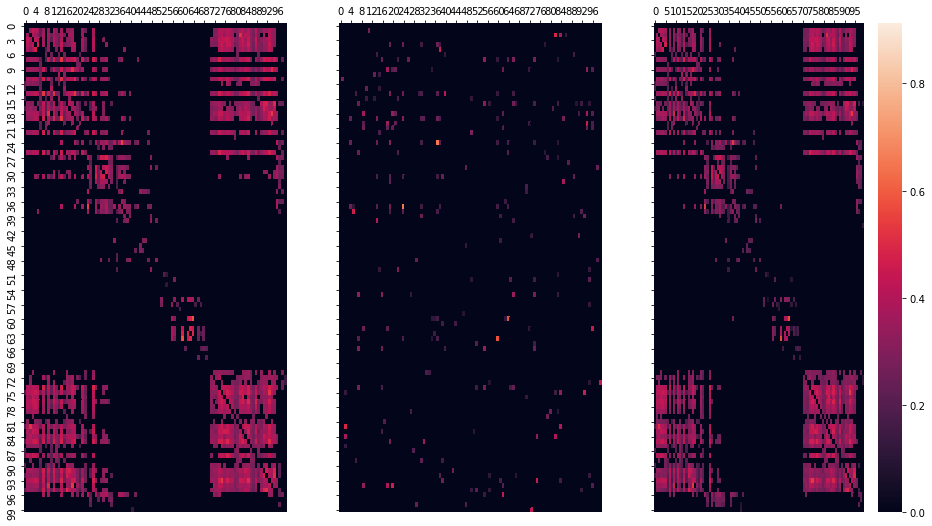

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cf_sim_max = cf_sim.max()
cbf_sim_max = cbf_sim.max()
cfcbf_sim_max = cfcbf_sim.max()
vmax = np.max([cf_sim_max, cbf_sim_max, cfcbf_sim_max])

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.heatmap(cf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1)
sns.heatmap(cbf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2)
sns.heatmap(cfcbf_sim[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3)
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")

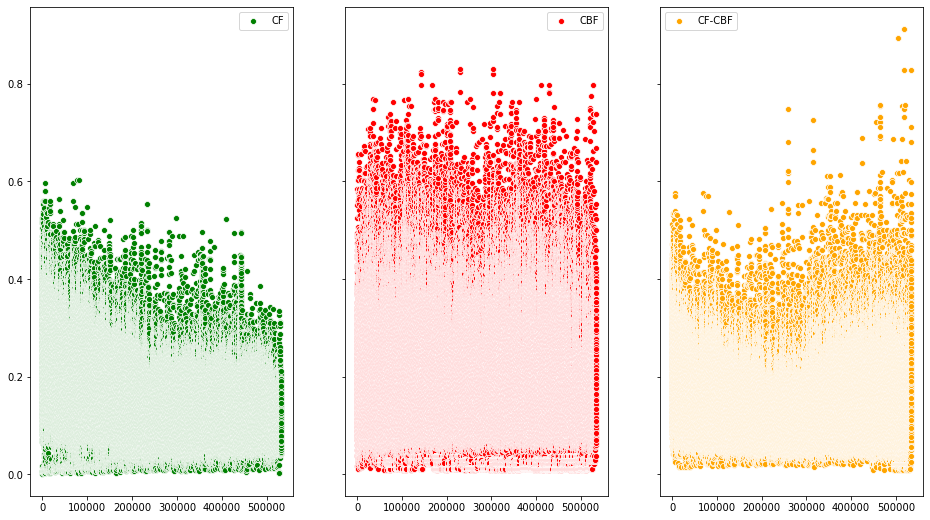

In [65]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_sim.data, ax=ax1, color="green")
sns.scatterplot(data=cbf_sim.data, ax=ax2, color="red")
sns.scatterplot(data=cfcbf_sim.data, ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

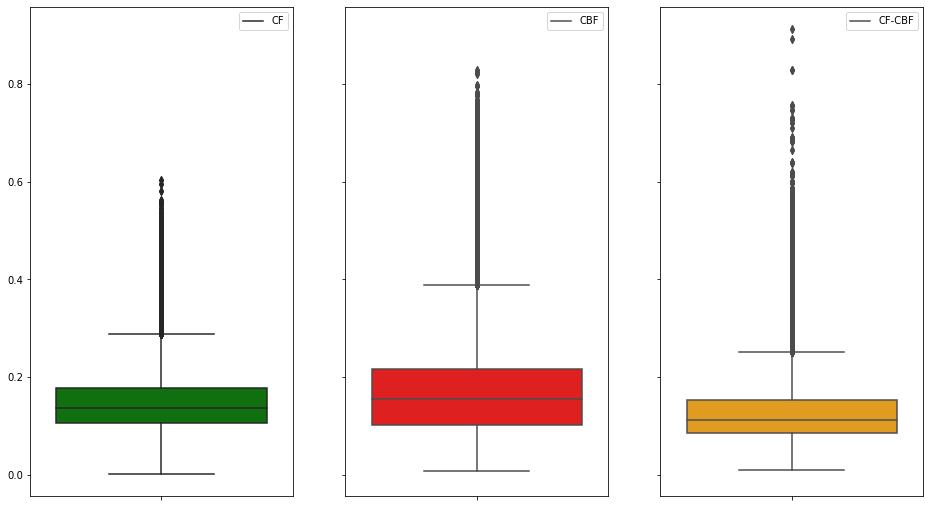

In [66]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.boxplot(x=cf_sim.data, orient="v", ax=ax1, color="green")
sns.boxplot(x=cbf_sim.data, orient="v", ax=ax2, color="red")
sns.boxplot(x=cfcbf_sim.data, orient="v", ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

Do you remember Bob (`user_id = 42`) and Toy Story (`item_id = 15`)?


In [67]:
cb_toy_story_sim = itemknn_cbf_recommender.W_sparse[15, :].todense().A.flatten()
cb_toy_story_sim

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [68]:
cf_toy_story_sim = itemKNNCF.W_sparse[15, :].todense().A.flatten()
cf_toy_story_sim

array([0.17453197, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [69]:
cfcbf_toy_story_sim = itemknn_cf_cbf_w_recommender.W_sparse[15, :].todense().A.flatten()
cfcbf_toy_story_sim

array([0.15559725, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

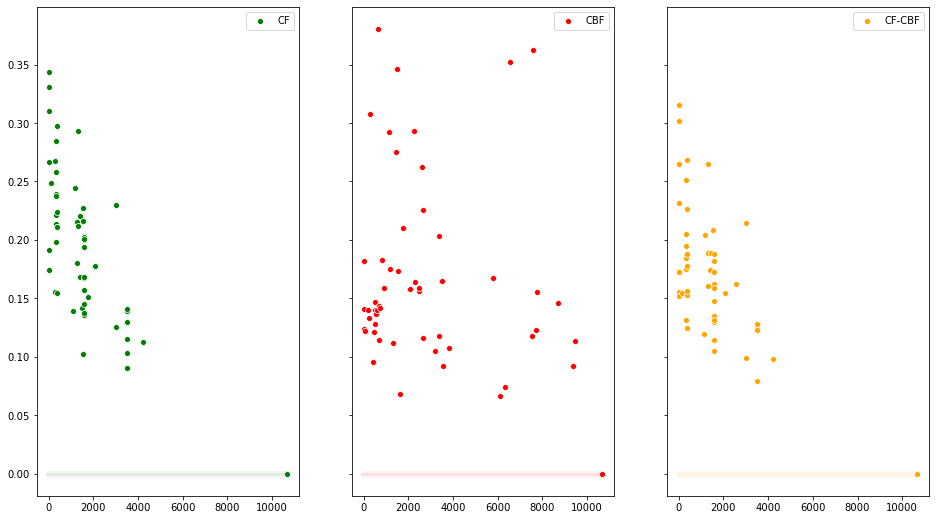

In [70]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_toy_story_sim, ax=ax1, color="green")
sns.scatterplot(data=cb_toy_story_sim, ax=ax2, color="red")
sns.scatterplot(data=cfcbf_toy_story_sim, ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

In [71]:
cb_recs = itemknn_cbf_recommender.recommend(user_id_array=[42], cutoff=10, remove_seen_flag=True)
cb_recs = np.array(cb_recs).flatten()
cb_recs

array([ 381, 2315, 5165, 2960, 2113,   26, 5011, 2392, 5012, 2316])

In [72]:
cf_recs = itemKNNCF.recommend(user_id_array=[42], cutoff=10, remove_seen_flag=True)
cf_recs = np.array(cf_recs).flatten()
cf_recs

array([2003,  237, 1253, 2113, 2116, 2492,  158,  163, 2114,  232])

In [73]:
cbcbf_recs = itemknn_cf_cbf_w_recommender.recommend(user_id_array=[42], cutoff=10, remove_seen_flag=True)
cbcbf_recs = np.array(cbcbf_recs).flatten()
cbcbf_recs

array([2003,  237, 2113, 2116, 1253, 2492,  158,  146,  230,  163])

In [74]:
print(set(cb_recs).intersection(cf_recs))
print(set(cb_recs).intersection(cbcbf_recs))
print(set(cf_recs).intersection(cbcbf_recs))
print(set(cbcbf_recs) - set(cf_recs))

{2113}
{2113}
{2113, 163, 2116, 1253, 237, 2003, 2492, 158}
{146, 230}


### Quick Recap

We have seen an specific case of CF-CBF hybrid, where we join together the ICM and the URM used for training. We also inspected the similarities and recommendations of each model and the hybrid.

We can still create hybrids the way we did before, i.e., by merging their models (ItemKNN + P3Alpha), or their item scores (PureSVD + ItemKNN), even if their optimization functions are different (SLIMBPR + FunkSVD).

## User-wise hybrid

Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model.

Let's categorize user based on the number of interactions they have.

In [75]:
bob_profile_start = URM_train.indptr[42]
bob_profile_ends = URM_train.indptr[42+1]
print(bob_profile_start, bob_profile_ends, bob_profile_ends - bob_profile_start)

URM_train.indices[bob_profile_start:bob_profile_ends], URM_train.indices[bob_profile_start:bob_profile_ends].shape

3736 4006 270


(array([   7,   24,   34,   43,   44,   45,   51,   56,   97,  103,  107,
         123,  132,  133,  144,  145,  147,  148,  149,  150,  151,  154,
         155,  156,  159,  160,  166,  167,  169,  170,  171,  174,  176,
         182,  191,  192,  198,  217,  218,  219,  220,  221,  222,  223,
         224,  225,  226,  227,  231,  235,  236,  239,  245,  249,  250,
         251,  260,  264,  265,  268,  271,  273,  278,  337,  391,  394,
         395,  402,  403,  411,  417,  430,  468,  487,  489,  506,  516,
         523,  584,  605,  612,  625,  632,  731,  739,  744,  787,  793,
         795,  887,  994, 1008, 1026, 1028, 1041, 1046, 1049, 1054, 1057,
        1061, 1066, 1070, 1071, 1073, 1074, 1075, 1076, 1092, 1093, 1095,
        1098, 1184, 1186, 1187, 1199, 1251, 1252, 1281, 1292, 1305, 1310,
        1337, 1342, 1368, 1426, 1438, 1439, 1441, 1442, 1446, 1464, 1465,
        1466, 1475, 1480, 1545, 1664, 1736, 1743, 1819, 1824, 1903, 1951,
        1974, 1977, 1982, 2001, 2002, 

As we can see, the `indptr` array can be used to determine the number of elements each user has interacted with. We only need the difference between where their profile starts and where it ends (`bob_profile_ends - bob_profile_start`).

Let's calculate this for all users using the `np.ediff1d` function.

In [76]:
profile_length = np.ediff1d(URM_train.indptr)
profile_length, profile_length.shape

(array([ 16,  17,  20, ..., 112,  41,  33], dtype=int32), (69878,))

Let's select a few groups of 5% of the users with the least number of interactions.

In [77]:
block_size = int(len(profile_length)*0.05)
block_size

3493

In [78]:
sorted_users = np.argsort(profile_length)
sorted_users

array([ 6472, 36062, 36384, ..., 14085, 65888, 57959])

In [79]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 3493, average p.len 13.65, median 14.0, min 6, max 15
Group 1, #users in group 3493, average p.len 16.51, median 17.0, min 15, max 18
Group 2, #users in group 3493, average p.len 18.72, median 19.0, min 18, max 20
Group 3, #users in group 3493, average p.len 21.14, median 21.0, min 20, max 23
Group 4, #users in group 3493, average p.len 24.03, median 24.0, min 23, max 26
Group 5, #users in group 3493, average p.len 27.29, median 27.0, min 26, max 29
Group 6, #users in group 3493, average p.len 31.10, median 31.0, min 29, max 33
Group 7, #users in group 3493, average p.len 35.50, median 35.0, min 33, max 38
Group 8, #users in group 3493, average p.len 40.44, median 40.0, min 38, max 43
Group 9, #users in group 3493, average p.len 46.28, median 46.0, min 43, max 50
Group 10, #users in group 3493, average p.len 53.58, median 54.0, min 50, max 58
Group 11, #users in group 3493, average p.len 62.60, median 62.0, min 58, max 68
Group 12, #users in group 3493, average

Now let's calculate the evaluation metrics of each recommender when considering groups of users.

In [80]:
from Base.NonPersonalizedRecommender import TopPop

top_pop = TopPop(URM_train)
top_pop.fit()

TopPopRecommender: URM Detected 51 (0.48 %) cold items.


In [88]:
MAP_recommender_per_group = {}

recommenders = [("TopPop", top_pop),
                ("ItemKNNCF", itemKNNCF),
                ("P3alpha", P3alpha),
                ("PureSVD", pureSVD),
                ("FunkSVD", funk_svd_recommender),
                ("SLIMBPR", slim_bpr_recommender),
                ("ItemKNNCBF", itemknn_cbf_recommender),
                ("ItemKNNCF + P3alpha", hybridrecommender),
                ("ItemKNNCF + PureSVD", scoreshybridrecommender),
                ("FunkSVD + SLIMBPR", difflossscoreshybridrecommender),
                ("ItemKNNCFCBF", itemknn_cf_cbf_w_recommender),
                ]
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommenders:
        results, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(results[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [results[cutoff]["MAP"]]
        

Group 0, #users in group 3493, average p.len 13.65, median 14.0, min 6, max 15
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.53 sec. Users per second: 2282
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.74 sec. Users per second: 2006
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.65 sec. Users per second: 2122
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.95 sec. Users per second: 1787
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 2.00 sec. Users per second: 1745
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.58 sec. Users per second: 2203
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.55 sec. Users per second: 2252
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.57 sec. Users per second: 2223
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.97 sec. Users per second: 1770
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 2.41 sec. Users per second: 1446
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.59 sec. Users per seco

EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.59 sec. Users per second: 2191
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.67 sec. Users per second: 2092
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.47 sec. Users per second: 2384
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.77 sec. Users per second: 1974
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.93 sec. Users per second: 1812
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.70 sec. Users per second: 2060
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.67 sec. Users per second: 2097
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.71 sec. Users per second: 2047
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.02 sec. Users per second: 1728
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.51 sec. Users per second: 1392
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.75 sec. Users per second: 1991
Group 9, #users in group 3493, average p.len 46.28, median 46.0, min 43, max 50
EvaluatorHoldout: Ignoring 66

EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.59 sec. Users per second: 2195
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.81 sec. Users per second: 1932
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.01 sec. Users per second: 1734
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.02 sec. Users per second: 1730
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.02 sec. Users per second: 1725
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.06 sec. Users per second: 1694
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.34 sec. Users per second: 1491
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.80 sec. Users per second: 1249
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.08 sec. Users per second: 1682
Group 17, #users in group 3493, average p.len 206.88, median 206.0, min 178, max 241
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.71 sec. Users per second: 2046
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.23 sec. Users pe

{'TopPop': [0.04418421392834849, 0.04908800837303047, 0.0512640200764557, 0.05502591622846842, 0.0552663829432624, 0.054162490044331484, 0.05448342459040368, 0.0567463567851247, 0.05621587508782812, 0.06199656331343179, 0.06165113529798686, 0.07350542674630482, 0.08185633297332899, 0.08953013737225039, 0.09959462007916084, 0.11497960774156028, 0.13522708682671442, 0.16464289122462608, 0.20600374217823395, 0.3125900440336459], 'ItemKNNCF': [0.12320449391467982, 0.1259395835327141, 0.1288684006989416, 0.13447302248903803, 0.1361790443280386, 0.1418152487432707, 0.13201424599314482, 0.13885960615756923, 0.1356808194458242, 0.14085355306408795, 0.14688247792781706, 0.1635678296989184, 0.1732469076474944, 0.18684456214015271, 0.20150474418224135, 0.2261815013246449, 0.25580907847440876, 0.29294041597935144, 0.3451212515734425, 0.4334248088012779], 'P3alpha': [0.12354065284953226, 0.12576748728861692, 0.13076636944412726, 0.13809692586067174, 0.13208792565473132, 0.13078231238341403, 0.12392

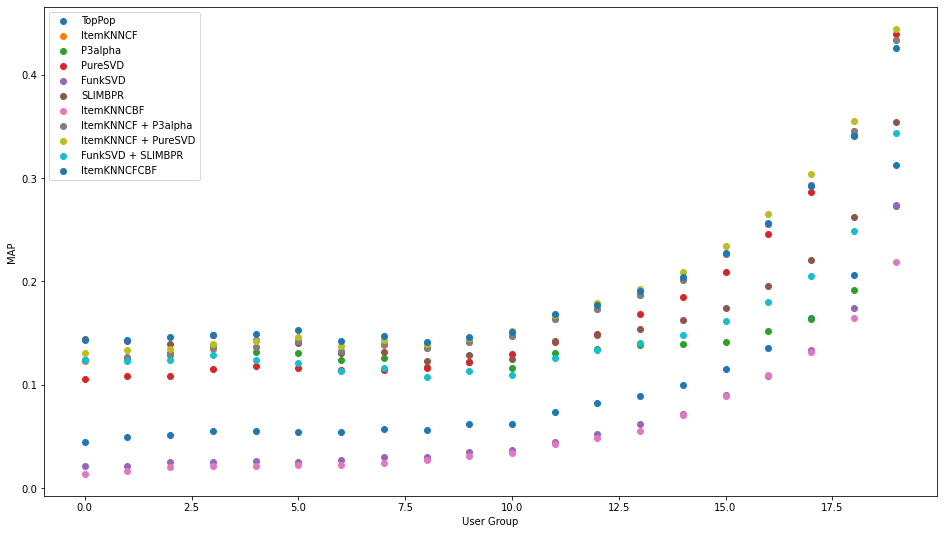

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommenders:
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### The recommendation quality of the three algorithms changes depending on the user profile length

## Tip:
### If an algorithm works best on average, it does not imply it will work best for ALL user types